### Gensim Word2vec

In [1]:
import os
import gensim
import multiprocessing
import pandas as pd

In [2]:
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
cores = multiprocessing.cpu_count()
print (cores)

12


#### 1. Carregar os Dados

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = '../../data/full_text_financial_news_vectors.txt'
tmp_file = get_tmpfile("test_w2v_suno.txt")

_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

loaded_model = model

### Gensim Embeddings Functions

In [5]:
# Most similar words to <example>
example = "ibovespa"
print(loaded_model.wv.most_similar(positive=example))

[('dólar', 0.6258866786956787), ('ibov', 0.6070651412010193), ('fechou', 0.5778346061706543), ('benchmark', 0.5752573609352112), ('alta', 0.5714282989501953), ('queda', 0.5571151971817017), ('pregão', 0.5556570887565613), ('índice', 0.5524358749389648), ('altas', 0.5390991568565369), ('pregões', 0.5346744060516357)]


In [6]:
words = ['lucro', 'prejuízo']
loaded_model.wv.similarity(words[0], words[1])

0.72173196

In [7]:
# Find word not releated
words = ['lucro', 'prejuízo', 'receita']
loaded_model.wv.doesnt_match([words[0], words[1], words[2]])

'receita'

In [8]:
# Analogy
positives = ['lucro', 'líquido']
negative = ['prejuízo']

loaded_model.wv.most_similar(positive=[positives[0], positives[1]],
                             negative=[negative[0]],
                             topn=3)

[('ajustado', 0.6407305002212524),
 ('ebitda', 0.6199777126312256),
 ('recorrente', 0.6063035726547241)]

---

### Referência dos Códigos a Seguir

- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [9]:
def tsnescatterplot(model, ncomponents, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('red')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=ncomponents).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line],
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title("Visualização t-SNE para '{}'".format(word))

<IPython.core.display.Javascript object>


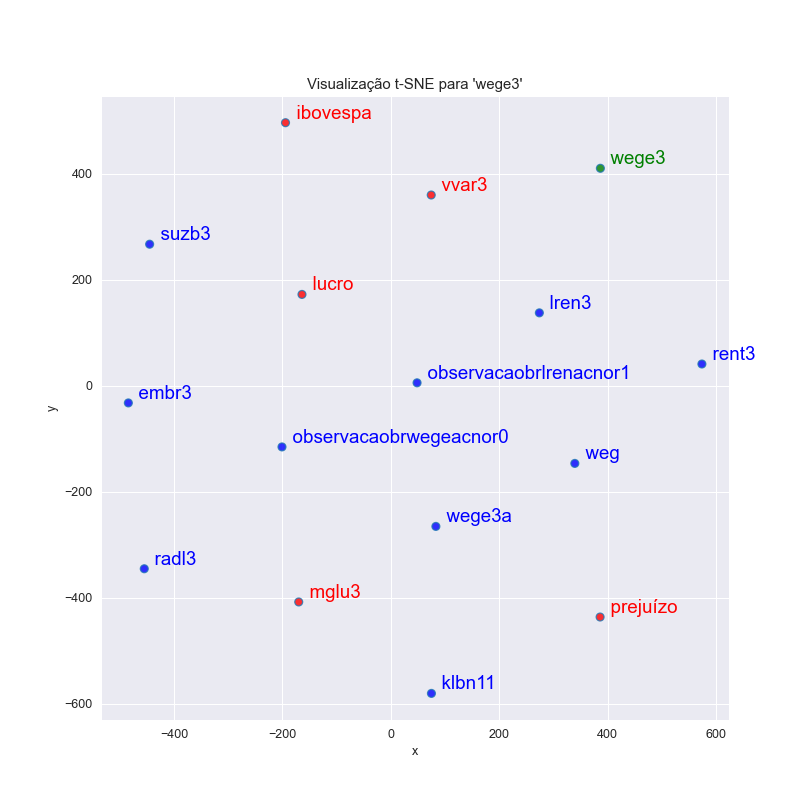

In [10]:
# 10 Most similar words vs. 5 Random words
tsnescatterplot(loaded_model,
                10,
                'wege3', ['mglu3', 'vvar3', 'ibovespa', 'lucro', 'prejuízo']) 

<IPython.core.display.Javascript object>


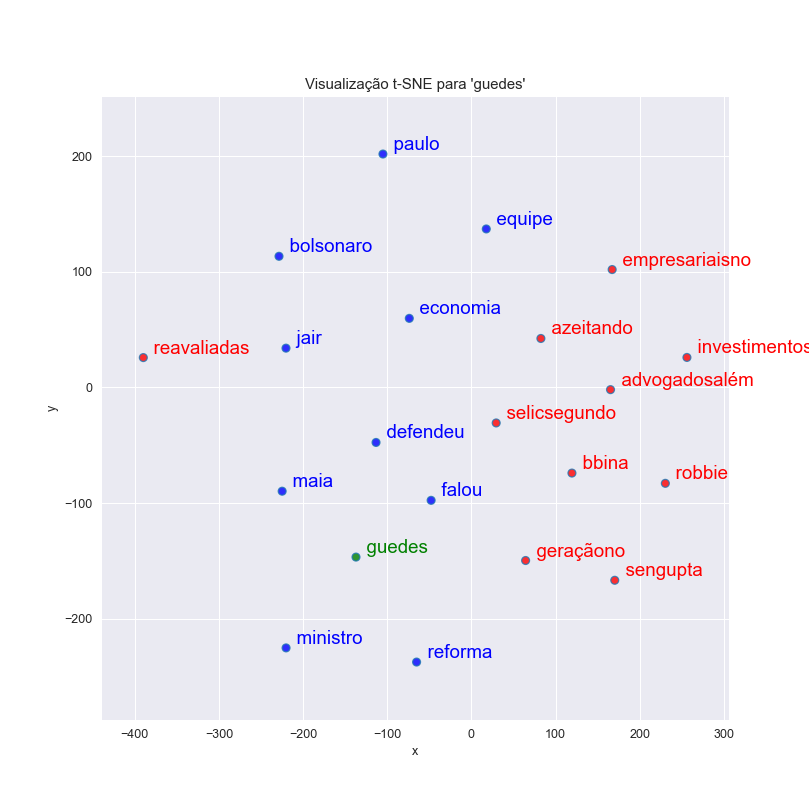

In [11]:
# 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(loaded_model,
                10,
                "guedes",
                [i[0] for i in loaded_model.wv.most_similar(negative=["maconha"])])

<IPython.core.display.Javascript object>


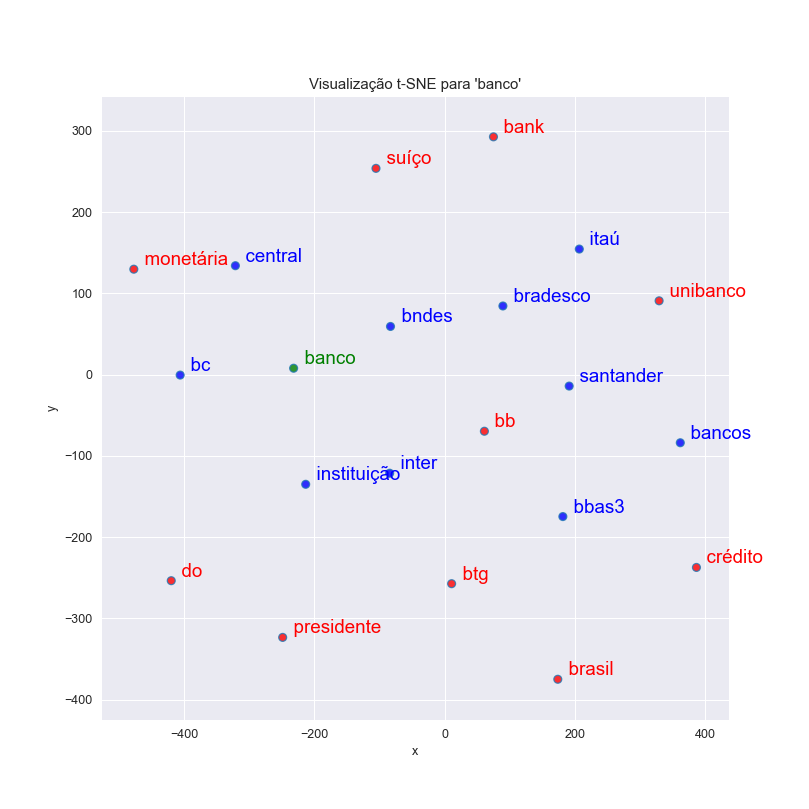

In [23]:
# 10 Most similar words vs. 11th to 20th Most similar words

word = 'banco'

tsnescatterplot(loaded_model,
                10,
                word,
                [t[0] for t in loaded_model.wv.most_similar(positive=[word], topn=20)][10:])

---